<a href="https://colab.research.google.com/github/priyasingh1901/lung-segmentation-using-unet-pso/blob/main/biolab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/lung-data/lungsegmentation.zip" -d /content

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
from pathlib import Path

IMG_PATH = Path("/content/lung segmentation/Chest-X-Ray/Chest-X-Ray/image")
MSK_PATH = Path("/content/lung segmentation/Chest-X-Ray/Chest-X-Ray/mask")
AUG_IMG_PATH = Path("/content/augmented data/augmented image")
AUG_MSK_PATH = Path("/content/augmented data/augmented masks")

# Only create if missing; otherwise do nothing
for p in (AUG_IMG_PATH, AUG_MSK_PATH):
    if not p.is_dir():
        p.mkdir(parents=True, exist_ok=True)

def load_data(image_path, mask_path):
    image = tf.io.read_file(str(image_path))
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (256, 256))
    mask = tf.io.read_file(str(mask_path))
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (256, 256))
    return image, mask

def augment_data(image, mask):
    augmented_images, augmented_masks = [], []
    for _ in range(3):
        aug_img, aug_mask = image, mask
        if tf.random.uniform(()) > 0.5:
            aug_img = tf.image.flip_left_right(aug_img)
            aug_mask = tf.image.flip_left_right(aug_mask)
        if tf.random.uniform(()) > 0.5:
            aug_img = tf.image.rot90(aug_img)
            aug_mask = tf.image.rot90(aug_mask)
        if tf.random.uniform(()) > 0.5:
            aug_img = tf.image.adjust_brightness(aug_img, delta=0.1)
        augmented_images.append(aug_img)
        augmented_masks.append(aug_mask)
    return augmented_images, augmented_masks

def save_augmented_dataset():
    image_files = sorted([p for p in IMG_PATH.iterdir() if p.suffix == ".png"])
    mask_files = sorted([p for p in MSK_PATH.iterdir() if p.suffix == ".png"])
    total = len(image_files)
    for count, (img_path, mask_path) in enumerate(zip(image_files, mask_files)):
        image, mask = load_data(img_path, mask_path)
        augmented_images, augmented_masks = augment_data(image, mask)
        tf.keras.utils.save_img(str(AUG_IMG_PATH / f"original_{count}.png"), image.numpy())
        tf.keras.utils.save_img(str(AUG_MSK_PATH / f"original_mask_{count}.png"), mask.numpy())
        for i, (aug_img, aug_mask) in enumerate(zip(augmented_images, augmented_masks)):
            tf.keras.utils.save_img(str(AUG_IMG_PATH / f"augmented_{count}_{i}.png"), aug_img.numpy())
            tf.keras.utils.save_img(str(AUG_MSK_PATH / f"augmented_mask_{count}_{i}.png"), aug_mask.numpy())
        if (count + 1) % 50 == 0 or (count + 1) == total:
            print(f"Saved augmentations for image {count + 1}/{total}")

save_augmented_dataset()


Saved augmentations for image 50/704
Saved augmentations for image 100/704
Saved augmentations for image 150/704
Saved augmentations for image 200/704
Saved augmentations for image 250/704
Saved augmentations for image 300/704
Saved augmentations for image 350/704
Saved augmentations for image 400/704
Saved augmentations for image 450/704
Saved augmentations for image 500/704
Saved augmentations for image 550/704
Saved augmentations for image 600/704
Saved augmentations for image 650/704
Saved augmentations for image 700/704
Saved augmentations for image 704/704


In [ ]:
# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

# Image Processing Libraries
import cv2
from cv2 import imread,resize
from scipy.ndimage import label, find_objects

# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# File and Operating System Libraries
import os

# Warnings Management
import warnings
warnings.filterwarnings('ignore')

# GPU Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(tf.config.list_physical_devices('GPU'))

# PATHS
IMG_PATH = '/content/lung segmentation/Chest-X-Ray/Chest-X-Ray/image'
MSK_PATH = '/content/lung segmentation/Chest-X-Ray/Chest-X-Ray/mask'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
metadata = pd.read_csv('/content/lung segmentation/MetaData.csv')
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       704 non-null    int64 
 1   gender   704 non-null    object
 2   age      704 non-null    object
 3   county   704 non-null    object
 4   ptb      704 non-null    int64 
 5   remarks  699 non-null    object
dtypes: int64(2), object(4)
memory usage: 33.1+ KB


In [ ]:
metadata.head()

,id,gender,age,county,ptb,remarks
0,1000,male,31,Shenxhen,0,normal
1,1001,male,64,Shenxhen,0,normal
2,1002,male,35,Shenxhen,0,normal
3,1003,male,32,Shenxhen,1,"STB,ATB,tuberculosis pleuritis"
4,1004,male,2,Shenxhen,1,secondary PTB in the bilateral upper field


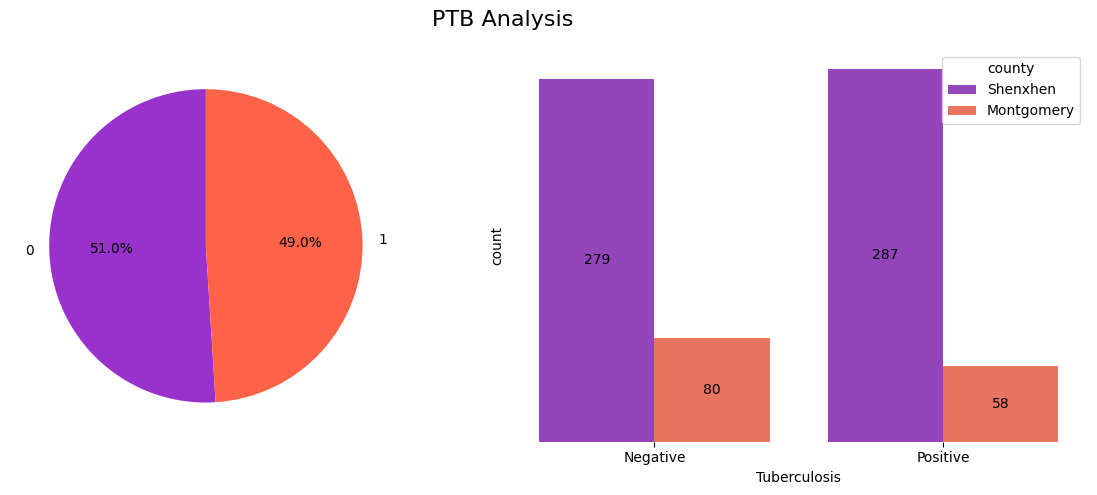

In [ ]:
agg_data = metadata.ptb.value_counts()
ct = pd.crosstab(metadata['gender'], metadata['ptb'])

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.pie(agg_data,labels=agg_data.index,autopct='%1.1f%%', startangle=90,colors=['darkorchid','tomato'])

plt.subplot(122)
bars = sns.countplot(metadata,x='ptb',hue='county',palette=['darkorchid','tomato'])
plt.bar_label(bars.containers[0], label_type='center')
plt.bar_label(bars.containers[1], label_type='center')
plt.yticks([])
plt.xticks([0,1],labels=['Negative','Positive'])
plt.xlabel('Tuberculosis')
plt.box(False)

plt.suptitle('PTB Analysis',fontsize=16)
plt.tight_layout()
plt.show()

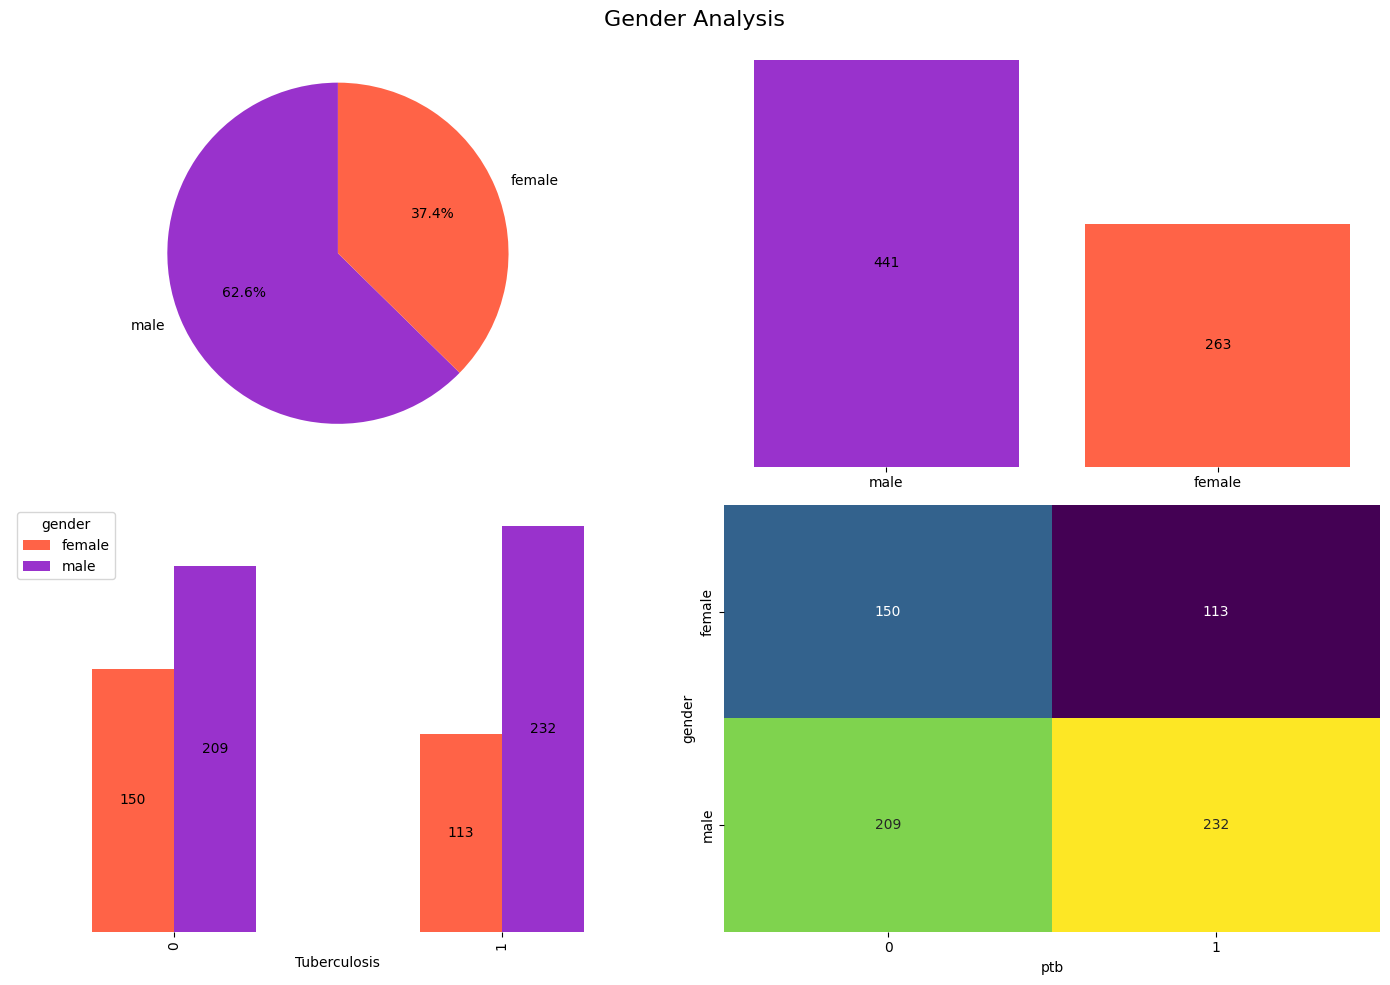

In [ ]:
gender_mapping = {
    'm': 'male', 'Male,': 'male', 'male35yrs': 'male', 'male,':'male',
    'f': 'female', 'femal': 'female', 'female24yrs':'female','o':'female','female,':'female'
}
metadata.gender = metadata.gender.str.lower()
metadata.gender.replace(gender_mapping,inplace=True)
agg_data = metadata.gender.value_counts()
ct = pd.crosstab(metadata['gender'], metadata['ptb'])

plt.figure(figsize=(14,10))
plt.subplot(221)
plt.pie(agg_data,labels=agg_data.index,autopct='%1.1f%%', startangle=90,colors=['darkorchid','tomato'])

plt.subplot(222)
bars = plt.bar(agg_data.index,agg_data,color=['darkorchid','tomato'])
plt.bar_label(bars, labels=[str(height) for height in agg_data],label_type='center')
plt.yticks([])
plt.box(False)

plt.subplot(223)
bars = ct.T.plot(kind='bar', color=['tomato', 'darkorchid'],ax=plt.gca())
plt.bar_label(bars.containers[0], label_type='center')
plt.bar_label(bars.containers[1], label_type='center')
plt.xlabel('Tuberculosis')
plt.yticks([])
plt.box(False)

plt.subplot(224)
sns.heatmap(ct,annot=True,cbar=False,fmt='d',cmap='viridis')

plt.suptitle('Gender Analysis',fontsize=16)
plt.tight_layout()
plt.show()

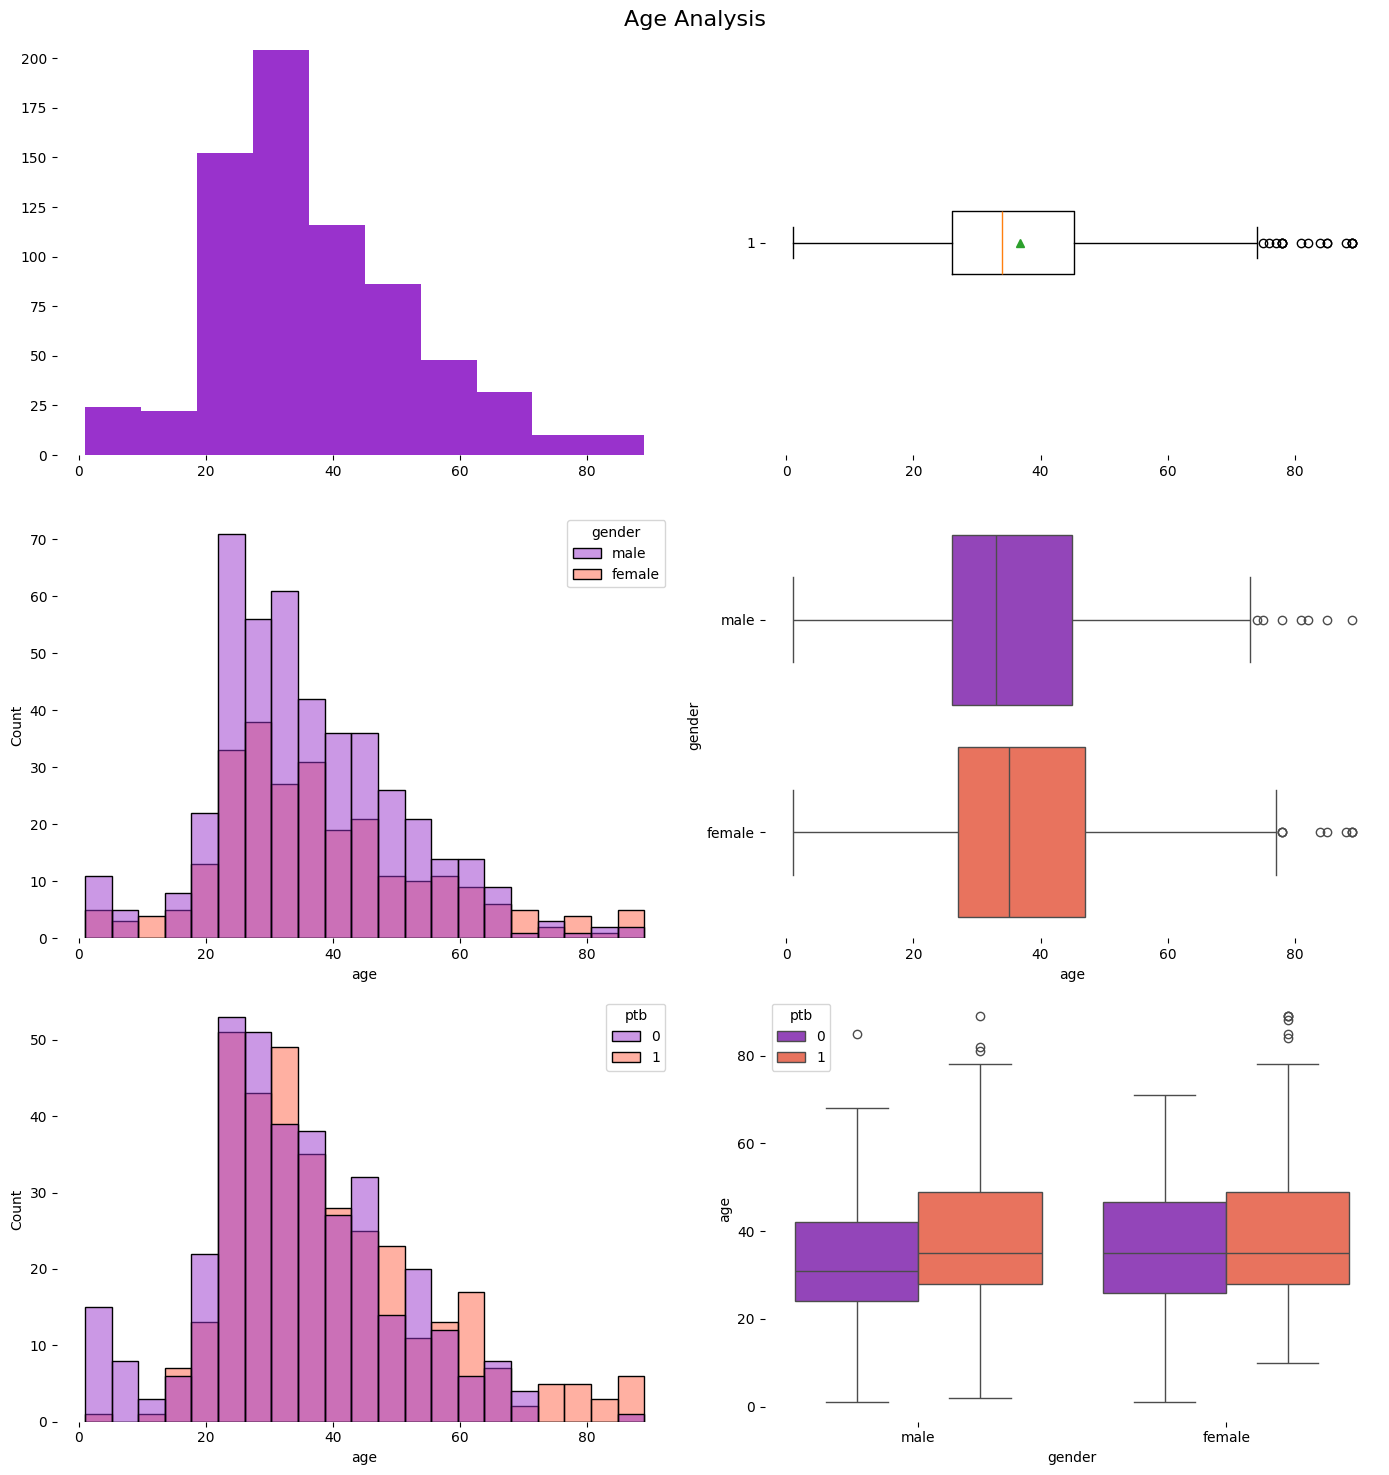

In [ ]:
metadata.age = (metadata.age
                .replace({'16month':'1','39yr':'39','1yr':'1','male35':'35','female24':'24'})
                .astype(int))
custom_palette = ['darkorchid','tomato']

plt.figure(figsize=(14,15))
plt.subplot(321)
plt.hist(metadata.age,color='darkorchid')
plt.box(False)

plt.subplot(322)
plt.boxplot(metadata.age,vert=False,showmeans=True)
plt.box(False)

plt.subplot(323)
sns.histplot(metadata,x='age',hue='gender',palette=custom_palette)
plt.box(False)

plt.subplot(324)
sns.boxplot(metadata,x='age',y='gender',palette=custom_palette)
plt.box(False)

plt.subplot(325)
sns.histplot(metadata,x='age',hue='ptb',palette=custom_palette)
plt.box(False)

plt.subplot(326)
sns.boxplot(data=metadata, x='gender', y='age', hue='ptb', palette=custom_palette)
plt.box(False)


plt.suptitle('Age Analysis',fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

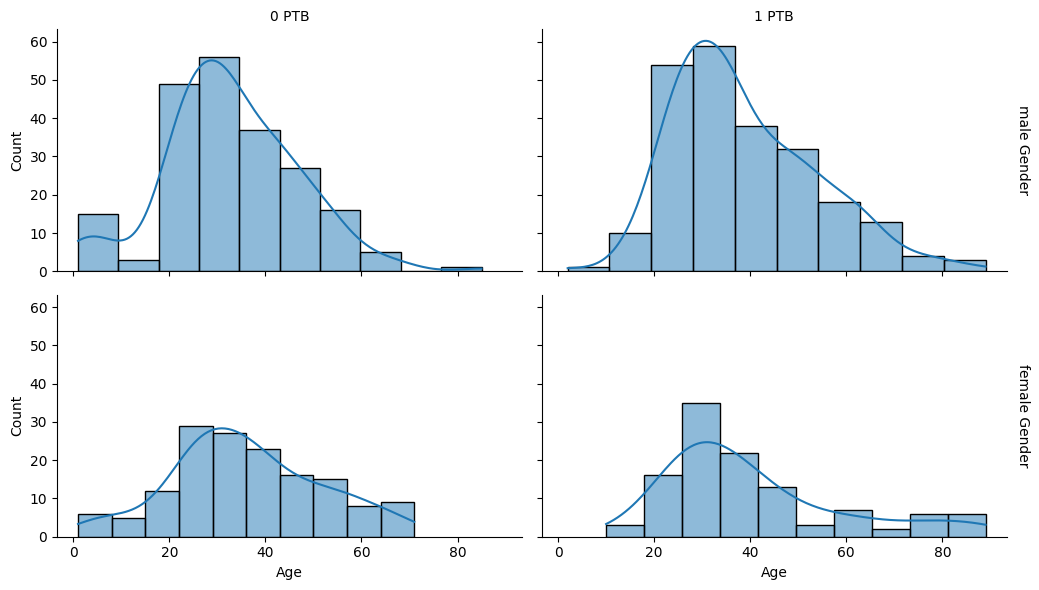

In [ ]:
# FacetGrid of Age by Gender and PTB
plt.figure(figsize=(14,8))
g = sns.FacetGrid(metadata, col='ptb', row='gender', margin_titles=True,aspect=1.75)
g.map(sns.histplot, 'age', bins=10, kde=True)

# Adding titles and labels
g.set_axis_labels('Age', 'Count')
g.set_titles(col_template="{col_name} PTB", row_template="{row_name} Gender")

# Show the plot
plt.show()


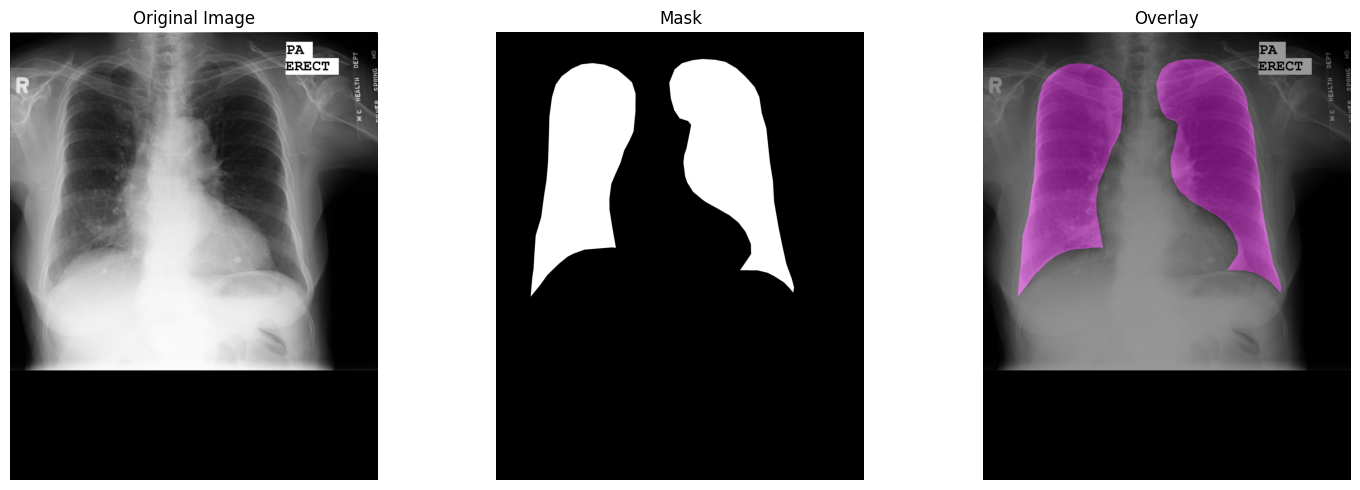

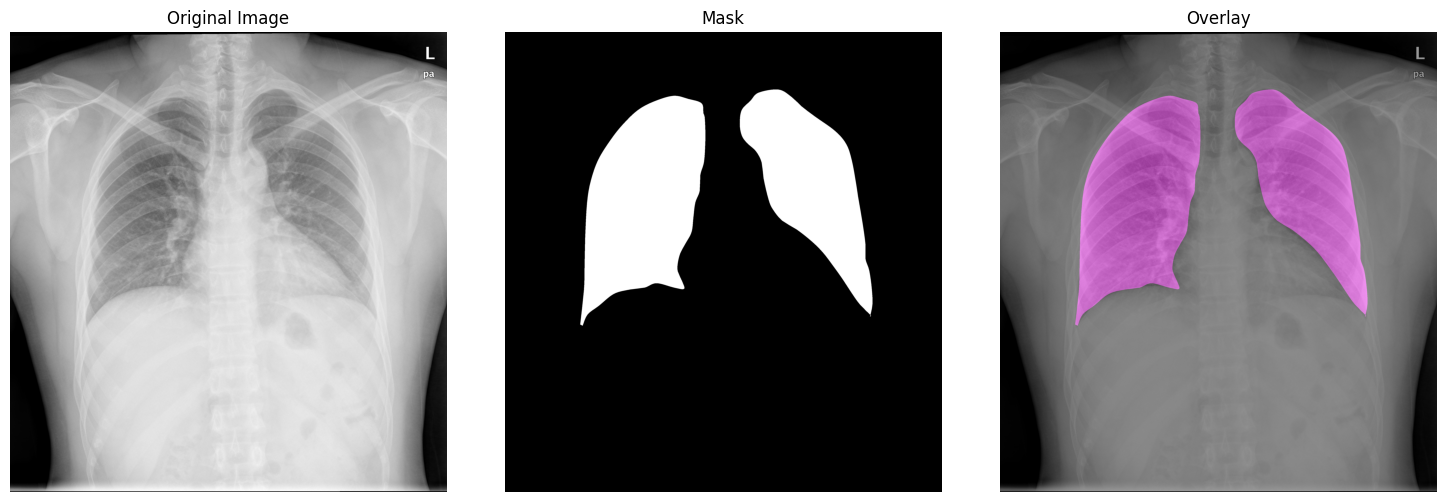

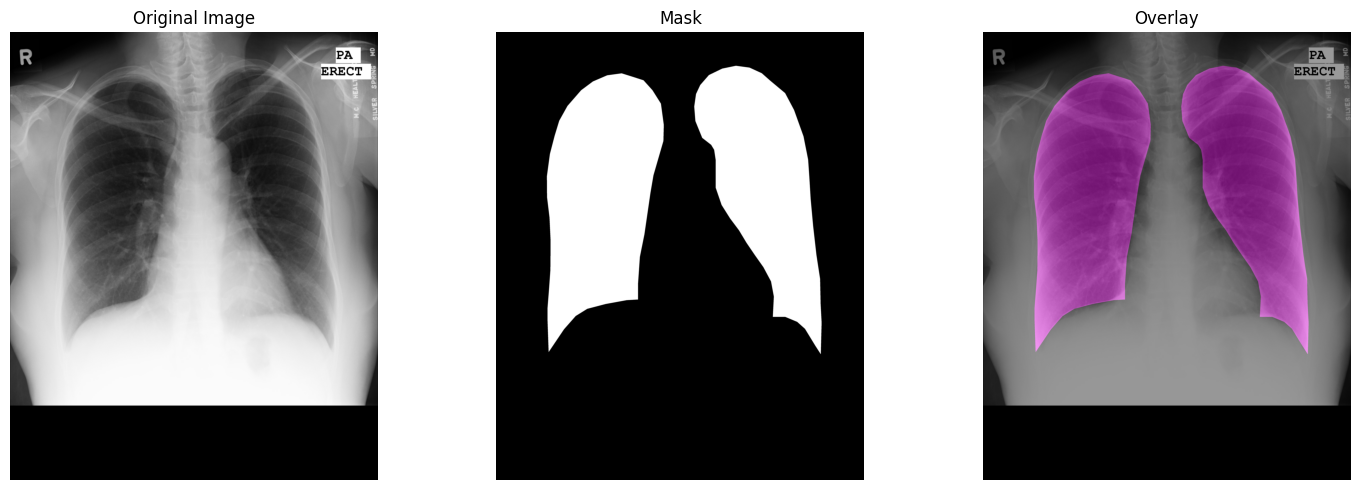

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def get_colored_mask(image, mask_image, color=[255, 20, 255]):
    if len(mask_image.shape) == 3:
        mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    else:
        mask_image_gray = mask_image

    mask = np.zeros_like(image)
    mask[mask_image_gray > 0] = color  # Colorize mask
    ret = cv2.addWeighted(image, 0.6, mask, 0.4, 0)
    return ret

# Load filenames (ensure only valid images)
filenames = [f for f in next(os.walk(IMG_PATH))[2] if f.endswith(('.png', '.jpg', '.jpeg'))][:3]

for file in filenames:
    # Load image
    img_path = os.path.join(IMG_PATH, file)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not load image {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Load mask
    msk_path = os.path.join(MSK_PATH, file)
    msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)  # Grayscale mask
    if msk is None:
        print(f"Error: Could not load mask {msk_path}")
        continue

    # Plot original image, mask, and overlay
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(msk, cmap='binary_r')
    plt.title("Mask")
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(get_colored_mask(img, msk))
    plt.title("Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


100%|██████████| 704/704 [00:27<00:00, 25.94it/s]


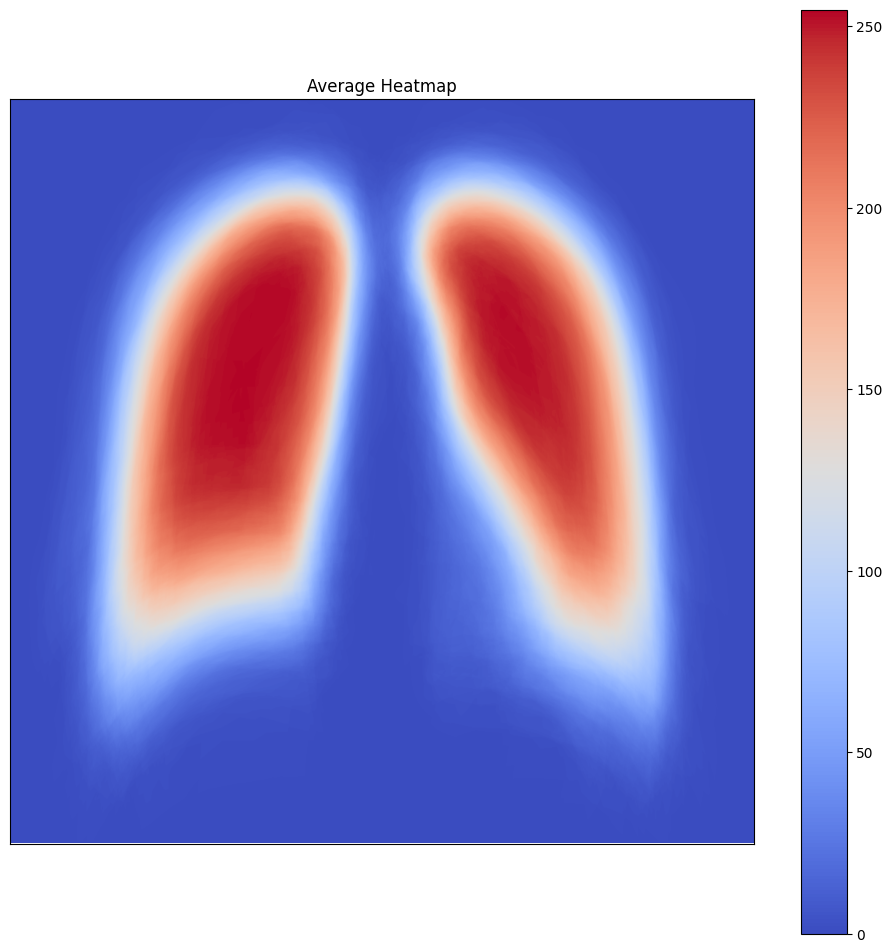

In [ ]:
from tqdm import tqdm
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Initialize heatmap with zeros
heatmap = np.zeros((1024, 1024))

# Ensure filenames include only valid images
filenames = [f for f in next(os.walk(MSK_PATH))[2] if f.endswith(('.png', '.jpg', '.jpeg'))]

for file in tqdm(filenames, total=len(filenames)):
    msk_path = os.path.join(MSK_PATH, file)

    # Read mask and handle errors
    msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
    if msk is None:
        print(f"Warning: Could not read mask file {msk_path}")
        continue

    # Resize mask to 1024x1024
    msk = cv2.resize(msk, (1024, 1024))

    # Accumulate the mask
    heatmap += msk

# Average the heatmap
if len(filenames) > 0:
    heatmap /= len(filenames)

# Plot the heatmap
plt.figure(figsize=(12, 12))
plt.imshow(heatmap, cmap='coolwarm')
plt.yticks([])
plt.xticks([])
plt.title("Average Heatmap")
plt.colorbar()
plt.show()


In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, img_files, mask_files, batch_size=32, size=(512, 512), shuffle=True):
        super().__init__()
        self.img_filenames = img_files
        self.mask_filenames = mask_files
        self.batch_size = batch_size
        self.size = size
        self.shuffle = shuffle
        assert len(self.img_filenames) == len(self.mask_filenames), "The number of images and masks must be the same"
        self.indexes = np.arange(len(self.img_filenames))
        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.img_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        images = []
        masks = []
        for idx in batch_indices:
            img_path = os.path.join(IMG_PATH, self.img_filenames[idx])
            mask_path = os.path.join(MSK_PATH, self.mask_filenames[idx])
            img = imread(img_path, 0)
            img = resize(img, self.size)
            img = img / 255.0
            mask = imread(mask_path, 0)
            mask = resize(mask, self.size)
            mask = np.expand_dims(mask, axis=-1)
            mask = mask / 255.0
            mask[mask > 0.5] = 1
            images.append(img)
            masks.append(mask)
        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

img_files, msk_files = sorted(os.listdir(IMG_PATH)), sorted(os.listdir(MSK_PATH))
train_img_files, val_img_files, train_msk_files, val_msk_files = train_test_split(img_files, msk_files, test_size=0.3, random_state=1)

train_data = DataGenerator(train_img_files, train_msk_files, batch_size=4, size=(512, 512))
val_data   = DataGenerator(val_img_files, val_msk_files, batch_size=4, size=(512, 512), shuffle=False)


In [ ]:
def unet(input_shape, num_classes, base_filters=64, dropout_rate=0.0):
    """Builds the U-Net model with tunable base filters and dropout."""
    inputs = layers.Input(shape=input_shape)

    def maybe_dropout(tensor):
        if dropout_rate and dropout_rate > 0:
            return layers.Dropout(dropout_rate)(tensor)
        return tensor

    filters = base_filters

    # Contracting Path (Encoder)
    conv1 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv1)
    pool1 = maybe_dropout(pool1)

    filters *= 2
    conv2 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)
    pool2 = maybe_dropout(pool2)

    filters *= 2
    conv3 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv3)
    pool3 = maybe_dropout(pool3)

    filters *= 2
    conv4 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = maybe_dropout(conv4)

    # Expansive Path (Decoder)
    filters //= 2
    up6 = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(conv4)
    merge6 = layers.concatenate([up6, conv3])
    conv6 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)

    filters //= 2
    up7 = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([up7, conv2])
    conv7 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)

    filters //= 2
    up8 = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([up8, conv1])
    conv8 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(conv8)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Instantiate the model with default hyperparameters
input_shape = (512, 512, 1)
model = unet(input_shape, 1)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 512, 512,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 512, 512,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 256, 256,  │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 256, 256,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_5[

 Total params: 7,707,457 (29.40 MB)

 Trainable params: 7,701,825 (29.38 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [ ]:
# Jaccard Index Metric
def jaccard_index(y_true, y_pred, smooth=100):
    """Calculates the Jaccard index (IoU), useful for evaluating the model's performance."""
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast ground truth
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast predictions
    intersection = tf.reduce_sum(y_true_f * y_pred_f)  # Compute intersection
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection  # Total pixels
    return (intersection + smooth) / (total + smooth)


def dice_coefficient(y_true, y_pred, smooth=1):
    # Flatten and cast true and predicted masks to float32
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast y_true to float32
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast y_pred to float32

    # Calculate the intersection between the true and predicted masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    # Calculate the Dice coefficient using the formula
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


# Using the metrics in model compilation
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',dice_coefficient,jaccard_index])

In [ ]:
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_model.keras',
    monitor='val_dice_coefficient',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,   # lower if you want faster
    callbacks=[checkpoint],
)


Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.8433 - dice_coefficient: 0.6461 - jaccard_index: 0.4905 - loss: 0.3885
Epoch 1: val_dice_coefficient improved from -inf to 0.39578, saving model to /content/drive/MyDrive/best_model.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.8437 - dice_coefficient: 0.6468 - jaccard_index: 0.4912 - loss: 0.3876 - val_accuracy: 0.2476 - val_dice_coefficient: 0.3958 - val_jaccard_index: 0.2479 - val_loss: 134.7973
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.9461 - dice_coefficient: 0.8222 - jaccard_index: 0.7016 - loss: 0.1529
Epoch 2: val_dice_coefficient improved from 0.39578 to 0.50817, saving model to /content/drive/MyDrive/best_model.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9461 - dice_coefficient: 0.8224 - jaccard_index: 0.7019 - loss: 0.1528 - val_accuracy: 0.5760 - val_dice_coefficient: 0.5082 - val_jaccard_index: 0.3429 - val_loss: 9.1998
Epoch 3/20
123/123 ━━━━━━━━

In [ ]:
# Capture the baseline validation metrics for later comparison
baseline_metrics = {
    "val_dice": max(history.history.get('val_dice_coefficient', [0])),
    "val_jaccard": max(history.history.get('val_jaccard_index', [0]))
}
baseline_metrics


{'val_dice': 0.9399421811103821, 'val_jaccard': 0.8870612382888794}

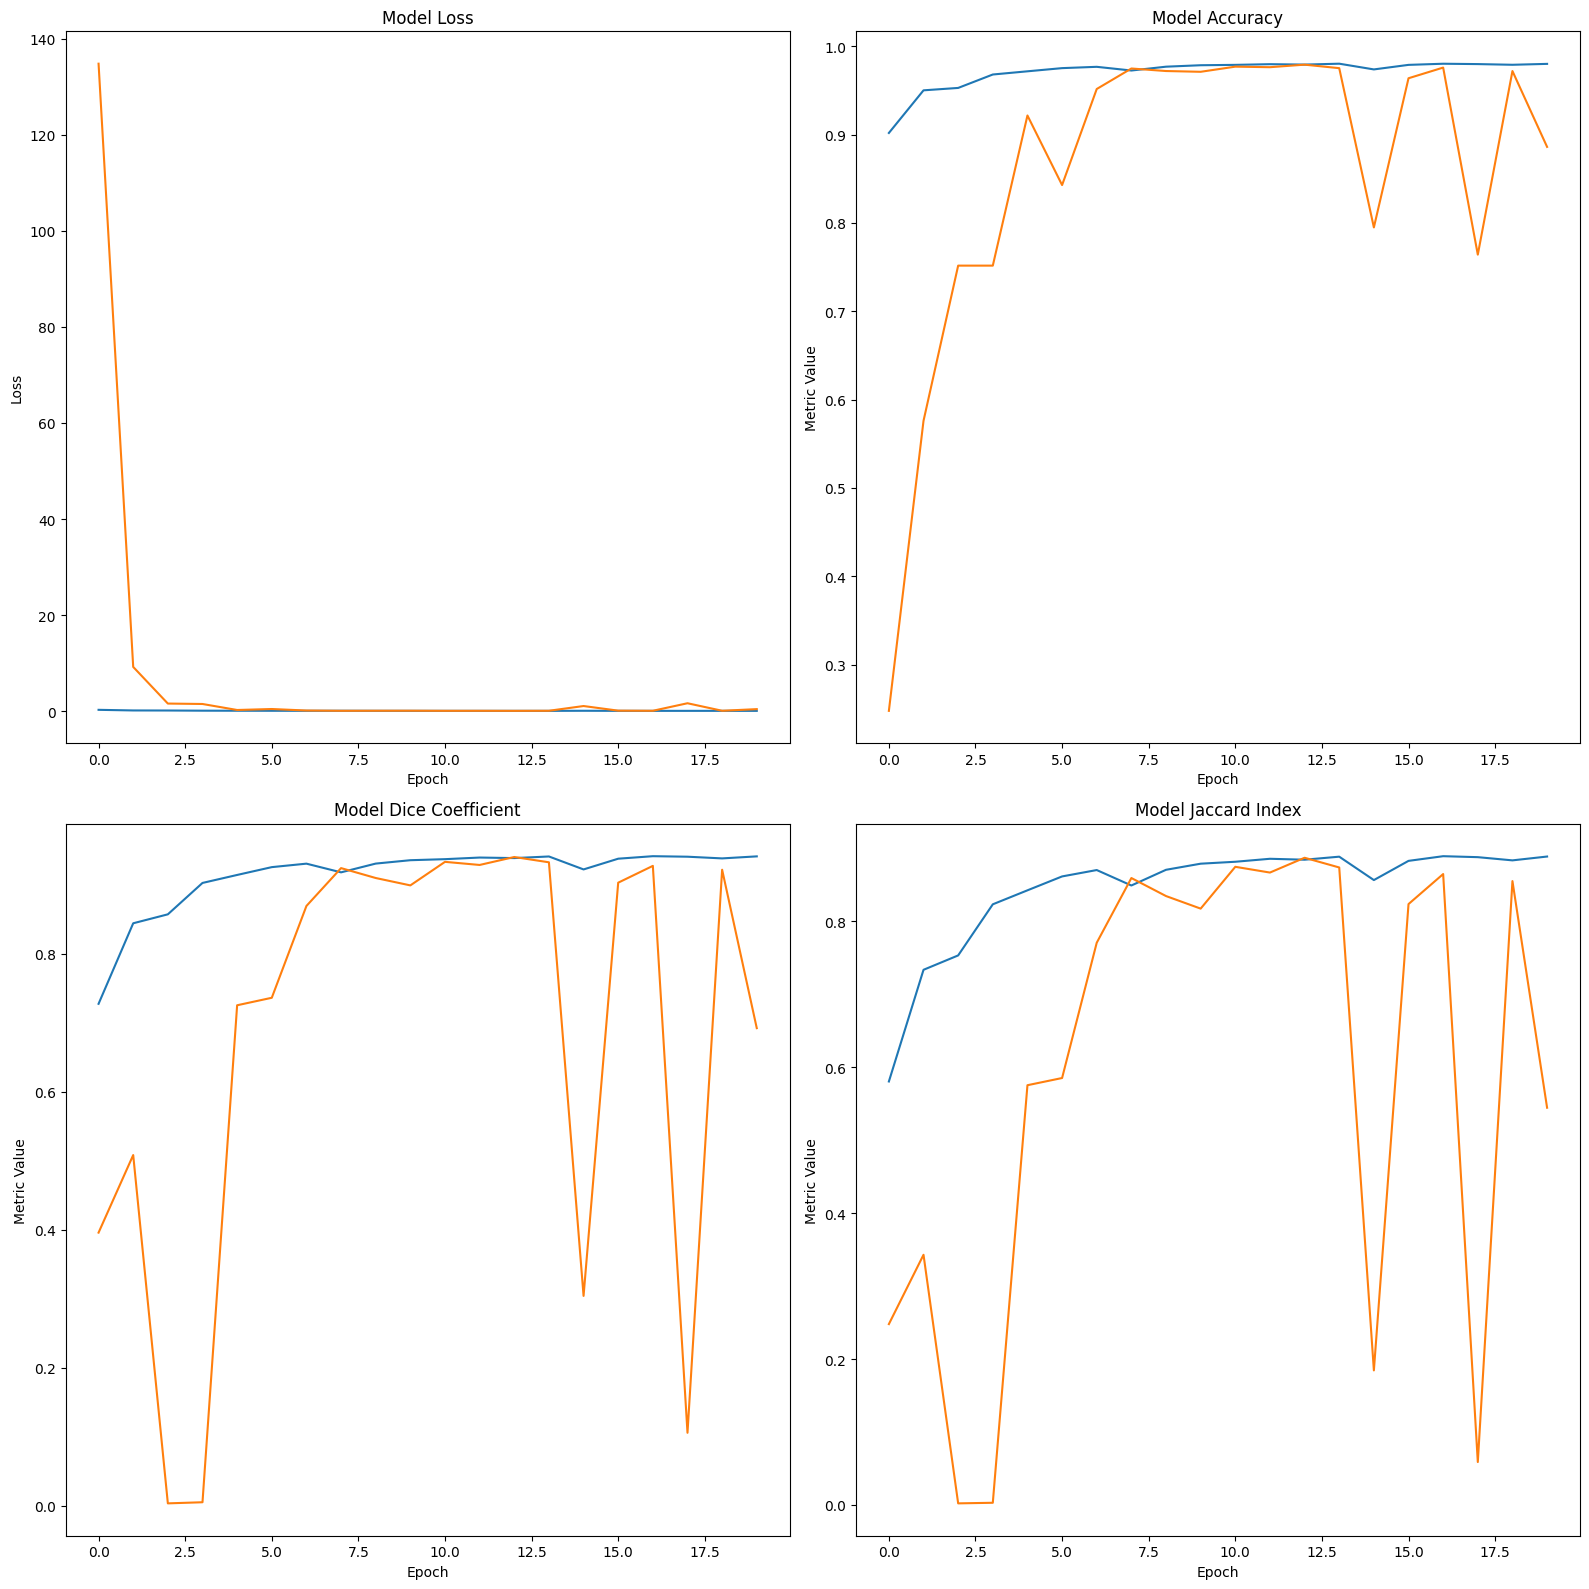

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(222)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.subplot(223)
plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Model Dice Coefficient')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.subplot(224)
plt.plot(history.history['jaccard_index'], label='Train Jaccard Index')
plt.plot(history.history['val_jaccard_index'], label='Validation Jaccard Index')
plt.title('Model Jaccard Index')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

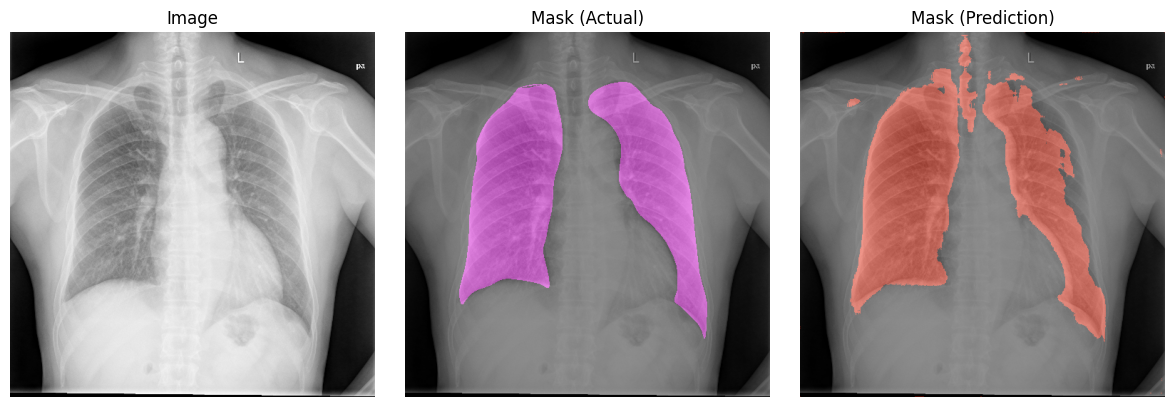

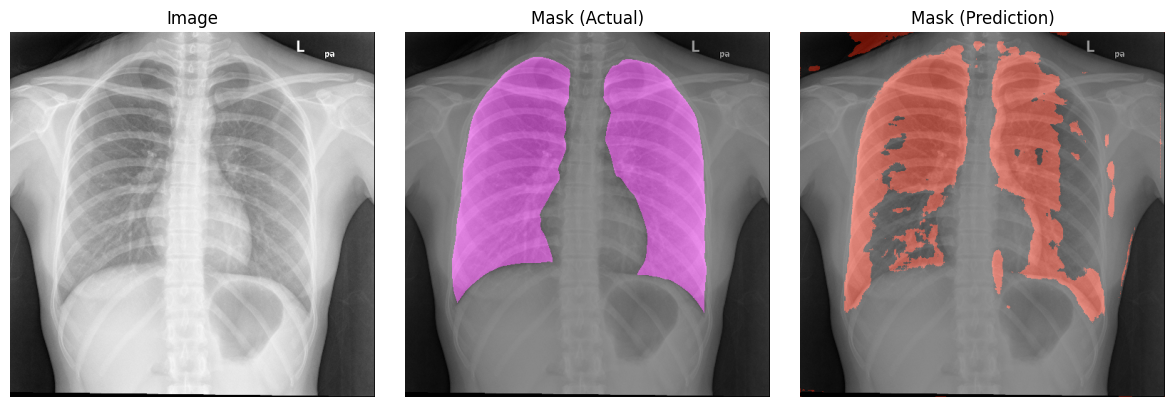

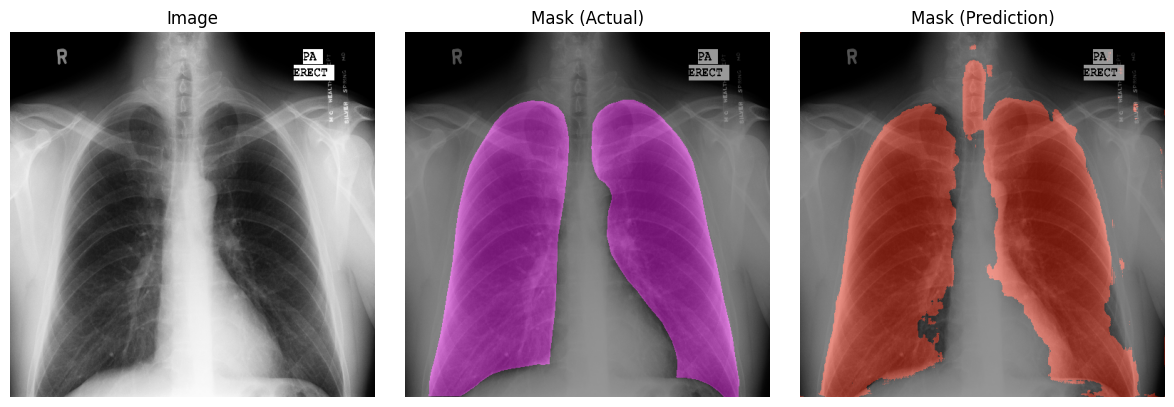

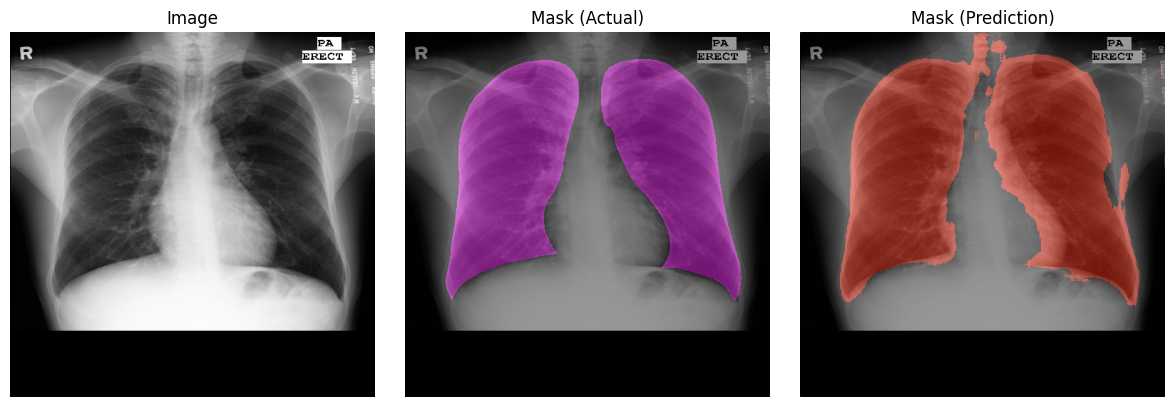

In [ ]:
imgs, msks  = val_data.__getitem__(1)

for img,msk in zip(imgs,msks):
    img = np.expand_dims(img, axis=0)
    pred = (np.squeeze(model.predict(img,verbose=0))*255).astype(np.uint8)
    img = (np.squeeze(img) * 255).astype(np.uint8)
    msk = (msk*255).astype(np.uint8)

    # Convert grayscale image to RGB
    img= cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    msk = cv2.cvtColor(msk, cv2.COLOR_GRAY2RGB)
    pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)

    plt.figure(figsize=(12,4))

    plt.subplot(131)
    plt.imshow(img)
    plt.title('Image')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(132)
    plt.imshow(get_colored_mask(img,msk))
    plt.title('Mask (Actual)')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(133)
    plt.imshow(get_colored_mask(img,pred,color = [255,30,0]))
    plt.title('Mask (Prediction)')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.tight_layout()
    plt.show()

## Rapid Hyperparameter Evaluation Helper
We reuse the `DataGenerator`, metrics, and U-Net definition to train for just a few epochs and report the best validation Dice/Jaccard for any given configuration. This lightweight scorer will be invoked repeatedly by PSO.


In [ ]:
import pandas as pd

BATCH_OPTIONS = np.array([4, 8, 16])
FILTER_OPTIONS = np.array([16, 32, 64])

def create_generators_for_batch(batch_size, shuffle=True):
    """Rebuild train/val generators for a specific batch size."""
    train_gen = DataGenerator(
        img_files=train_img_files,
        mask_files=train_msk_files,
        batch_size=batch_size,
        size=(512, 512),
        shuffle=shuffle
    )
    val_gen = DataGenerator(
        img_files=val_img_files,
        mask_files=val_msk_files,
        batch_size=batch_size,
        size=(512, 512),
        shuffle=False
    )
    return train_gen, val_gen

def train_unet_with_config(config, search_epochs=3, max_steps_per_epoch=10, max_val_steps=5):
    """Build, train briefly, and score a model with the provided hyperparameters."""
    tf.keras.backend.clear_session()

    batch_size   = int(config.get('batch_size', 8))
    learning_rate = float(config.get('learning_rate', 1e-3))
    base_filters  = int(config.get('base_filters', 64))
    dropout_rate  = float(config.get('dropout', 0.0))

    train_gen, val_gen = create_generators_for_batch(batch_size)

    model = unet(input_shape, 1, base_filters=base_filters, dropout_rate=dropout_rate)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', dice_coefficient, jaccard_index]
    )

    steps_per_epoch = min(len(train_gen), max_steps_per_epoch) if max_steps_per_epoch else len(train_gen)
    val_steps       = min(len(val_gen), max_val_steps)       if max_val_steps else len(val_gen)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=search_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=val_steps,
        verbose=0
    )

    best_val_dice = max(history.history.get('val_dice_coefficient', [0]))
    best_val_jaccard = max(history.history.get('val_jaccard_index', [0]))
    return best_val_dice, best_val_jaccard


## Particle Swarm Optimization (PSO)
Each particle encodes the learning rate, batch size, base number of filters, and dropout rate. After a short 3-epoch training run, the best validation Dice becomes the fitness score (with Jaccard logged for reference). The swarm iteratively nudges particles toward the strongest configurations via their personal best (pBest) and the global best (gBest).


In [ ]:
# Smaller search space
BATCH_OPTIONS = np.array([2, 4])
FILTER_OPTIONS = np.array([16, 32])

def create_generators_for_batch(batch_size, shuffle=True):
    target_size = (256, 256)  # lighter PSO eval size
    train_gen = DataGenerator(train_img_files, train_msk_files,
                              batch_size=batch_size, size=target_size, shuffle=shuffle)
    val_gen   = DataGenerator(val_img_files, val_msk_files,
                              batch_size=batch_size, size=target_size, shuffle=False)
    return train_gen, val_gen

def train_unet_with_config(config, search_epochs=1, max_steps_per_epoch=5, max_val_steps=2):
    tf.keras.backend.clear_session()
    batch_size = int(config.get('batch_size', 4))
    lr         = float(config.get('learning_rate', 1e-3))
    base_f     = int(config.get('base_filters', 16))
    dropout    = float(config.get('dropout', 0.0))

    train_gen, val_gen = create_generators_for_batch(batch_size)
    input_shape_pso = (256, 256, 1)  # match target_size
    model = unet(input_shape_pso, 1, base_filters=base_f, dropout_rate=dropout)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy', dice_coefficient, jaccard_index])

    steps  = min(len(train_gen), max_steps_per_epoch)
    vsteps = min(len(val_gen), max_val_steps)
    history = model.fit(train_gen, validation_data=val_gen,
                        epochs=search_epochs, steps_per_epoch=steps,
                        validation_steps=vsteps, verbose=0)

    best_val_dice    = max(history.history.get('val_dice_coefficient', [0]))
    best_val_jaccard = max(history.history.get('val_jaccard_index', [0]))

    del model, history
    import gc; gc.collect()
    tf.keras.backend.clear_session()
    return best_val_dice, best_val_jaccard

def decode_particle_position(position):
    lr = 10 ** np.clip(position[0], LR_BOUNDS[0], LR_BOUNDS[1])
    batch_idx  = int(np.clip(round(position[1]), 0, len(BATCH_OPTIONS) - 1))
    filter_idx = int(np.clip(round(position[2]), 0, len(FILTER_OPTIONS) - 1))
    dropout    = float(np.clip(position[3], DROPOUT_BOUNDS[0], DROPOUT_BOUNDS[1]))
    return {
        'learning_rate': lr,
        'batch_size': int(BATCH_OPTIONS[batch_idx]),
        'base_filters': int(FILTER_OPTIONS[filter_idx]),
        'dropout': dropout
    }

def run_pso(num_particles=2, iterations=2, inertia=0.5, c1=1.0, c2=1.5):
    particles, logs = [], []
    for _ in range(num_particles):
        pos = np.array([np.random.uniform(low, high) for (low, high) in DIM_BOUNDS])
        vel = np.zeros_like(pos)
        particles.append({'pos': pos, 'vel': vel, 'best_pos': pos.copy(),
                          'best_score': -np.inf, 'best_jaccard': -np.inf})
    global_best = {'pos': None, 'score': -np.inf, 'jaccard': -np.inf, 'config': None}

    for iteration in range(iterations):
        for idx, particle in enumerate(particles):
            config = decode_particle_position(particle['pos'])
            dice, jaccard = train_unet_with_config(config)

            if dice > particle['best_score']:
                particle['best_score'] = dice
                particle['best_jaccard'] = jaccard
                particle['best_pos'] = particle['pos'].copy()
            if dice > global_best['score']:
                global_best.update({'score': dice, 'jaccard': jaccard,
                                    'pos': particle['pos'].copy(), 'config': config})

            logs.append({
                'iteration': iteration + 1,
                'particle': idx + 1,
                'learning_rate': config['learning_rate'],
                'batch_size': config['batch_size'],
                'base_filters': config['base_filters'],
                'dropout': config['dropout'],
                'val_dice': dice,
                'val_jaccard': jaccard
            })

            r1 = np.random.rand(len(DIM_BOUNDS))
            r2 = np.random.rand(len(DIM_BOUNDS))
            cognitive = c1 * r1 * (particle['best_pos'] - particle['pos'])
            social = c2 * r2 * (global_best['pos'] - particle['pos']) if global_best['pos'] is not None else 0
            particle['vel'] = inertia * particle['vel'] + cognitive + social
            particle['pos'] = np.clip(particle['pos'] + particle['vel'], LOWER_BOUNDS, UPPER_BOUNDS)

    log_df = pd.DataFrame(logs)
    return global_best, log_df

LR_BOUNDS = (np.log10(1e-5), np.log10(1e-2))
BATCH_BOUNDS = (0, len(BATCH_OPTIONS) - 1)
FILTER_BOUNDS = (0, len(FILTER_OPTIONS) - 1)
DROPOUT_BOUNDS = (0.0, 0.5)
DIM_BOUNDS = [LR_BOUNDS, BATCH_BOUNDS, FILTER_BOUNDS, DROPOUT_BOUNDS]
LOWER_BOUNDS = np.array([b[0] for b in DIM_BOUNDS])
UPPER_BOUNDS = np.array([b[1] for b in DIM_BOUNDS])


In [ ]:
pso_best_result, pso_search_log = run_pso(num_particles=2, iterations=2)
pso_best_config = pso_best_result['config']
print('Best config via PSO:', pso_best_config)


Best config via PSO: {'learning_rate': np.float64(2.252121084615336e-05), 'batch_size': 2, 'base_filters': 16, 'dropout': 0.44614917309755675}


In [ ]:
pso_metrics = {
    "val_dice": float(pso_best_result['score']),
    "val_jaccard": float(pso_best_result['jaccard']),
}


In [ ]:
comparison_df = pd.DataFrame([
    {"Run": "Baseline", "Val Dice": baseline_metrics['val_dice'], "Val Jaccard": baseline_metrics['val_jaccard']},
    {"Run": "PSO Optimized", "Val Dice": pso_metrics['val_dice'], "Val Jaccard": pso_metrics['val_jaccard']}
])
comparison_df


,Run,Val Dice,Val Jaccard
0,Baseline,0.939942,0.887061
1,PSO Optimized,0.364200,0.223627


<Axes: title={'center': 'PSO val Dice per particle/iter'}, xlabel='particle', ylabel='val_dice'>

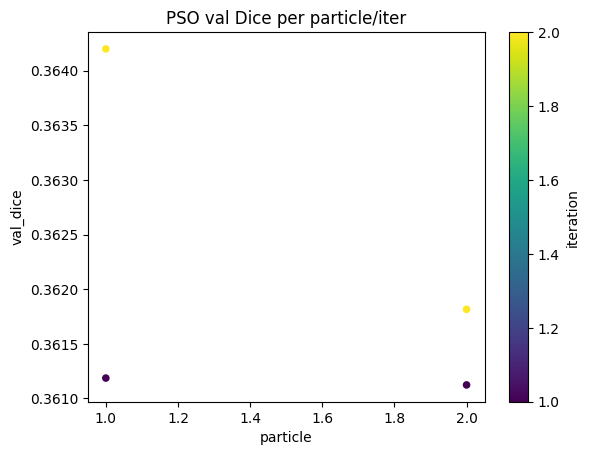

In [ ]:
pso_search_log.plot(kind='scatter', x='particle', y='val_dice', c='iteration', colormap='viridis', title='PSO val Dice per particle/iter')


<Axes: title={'center': 'Baseline vs PSO'}, xlabel='Run'>

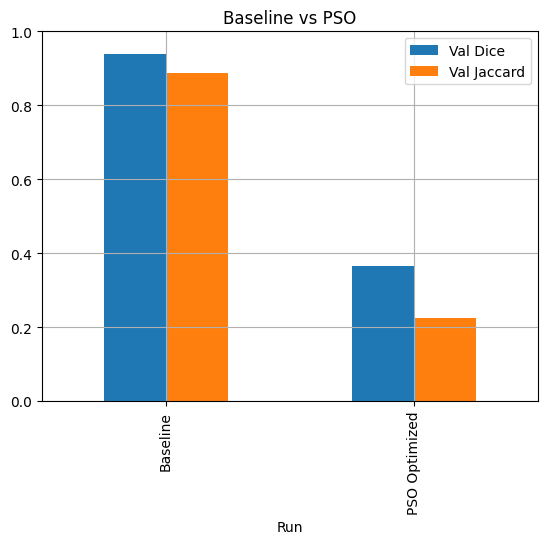

In [ ]:
comparison_df.set_index('Run')[['Val Dice','Val Jaccard']].plot(kind='bar', ylim=(0,1), grid=True, title='Baseline vs PSO')


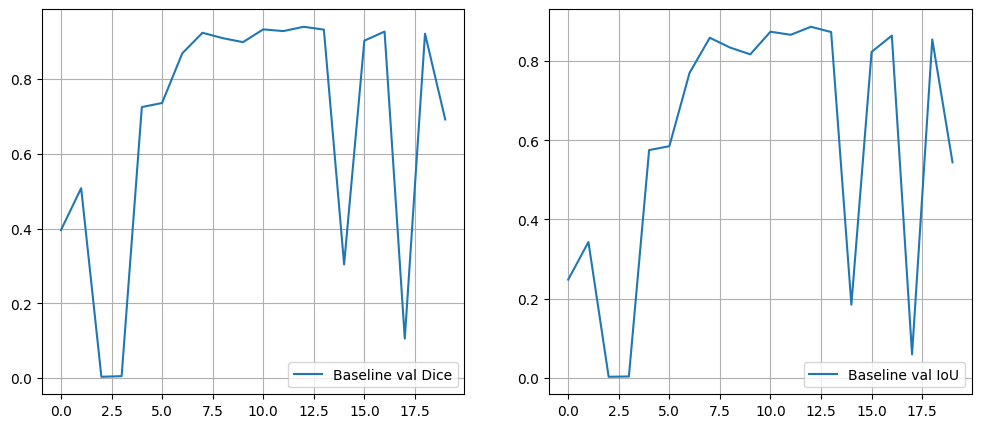

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(history.history['val_dice_coefficient'], label='Baseline val Dice'); plt.legend(); plt.grid(True)
plt.subplot(1,2,2); plt.plot(history.history['val_jaccard_index'], label='Baseline val IoU'); plt.legend(); plt.grid(True)
plt.show()
